# Loading Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import numpy as np
import matplotlib.pyplot as plt

# Load and transform CIFAR10 dataset

In [2]:
# Load CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Compare sizes of the original trainset and the augmented combined trainset
trainset_size = len(trainset)
testset_size = len(testset)

print(f"Trainset Size: {trainset_size}")
print(f"Testset Size: {testset_size}")

Trainset Size: 50000
Testset Size: 10000


In [4]:
# We can retrieve a sample from the dataset by simply indexing it
img, label = trainset[0]
print('Img shape: ', img.shape)
print('Label: ', label)

Img shape:  torch.Size([3, 32, 32])
Label:  6


In [5]:
# Similarly, we can sample a BATCH from the dataloader by running over its iterator
iter_ = iter(trainloader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print(f'The Batched tensors return a collection of {bimg.shape[0]} grayscale images ({bimg.shape[1]} channel, {bimg.shape[2]} height pixels, {bimg.shape[3]} width pixels)')
print(f'In the case of the labels, we obtain {blabel.shape[0]} batched integers, one per image')

Batch Img shape:  torch.Size([64, 3, 32, 32])
Batch Label shape:  torch.Size([64])
The Batched tensors return a collection of 64 grayscale images (3 channel, 32 height pixels, 32 width pixels)
In the case of the labels, we obtain 64 batched integers, one per image


# Define the CNN

Importantly, a convnet takes input tensors of shape `(batch, num_channels, image_height, image_width)`. In our case, we will configure our convnet to process inputs of size `(3, 32, 32)`, which is the format of `CIFAR` images.

In [6]:
# Custom CNN Architecture
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.LeakyReLU()
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.LeakyReLU()
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.relu6 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjust the size according to your input image dimensions
        self.relu7 = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(self.bn1(x))
        x = self.conv2(x)
        x = self.relu2(self.bn2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.relu3(self.bn3(x))
        x = self.conv4(x)
        x = self.relu4(self.bn4(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv5(x)
        x = self.relu5(self.bn5(x))
        x = self.conv6(x)
        x = self.relu6(self.bn6(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu7(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

# Define a class for memory analysis

In [7]:
# Let's define a class that encapsulates a collection of layers we pass in
# for each forwarded layer, it retains the amount of consumed memory for
# the returned feature map. It also displays the total amount used after
# all blocks are ran.
NUM_BITS_FLOAT32 = 32
class CNNMemAnalyzer(nn.Module):
    def __init__(self, cnn_model):
        super().__init__()
        self.cnn_model = cnn_model
        self.layers = list(cnn_model.children())

    def forward(self, x):
        tot_mbytes = 0
        layer_count = {}
        total_time = 0
        for i, layer in enumerate(self.layers):
            layer_type = type(layer).__name__
            layer_count[layer_type] = layer_count.get(layer_type, 0) + 1

            start_time = time.time()
            x = layer(x)
            end_time = time.time()

            elapsed_time = end_time - start_time
            total_time += elapsed_time

            mem_h_bytes = np.prod(x.shape) * 32 // 8  # Assuming float32
            mem_h_mb = mem_h_bytes / 1e6
            mem_h_kb = mem_h_bytes / 1e3

            print(f'Layer {i + 1}: {layer_type} #{layer_count[layer_type]}')
            print(f'Output shape: {x.shape}, Memory usage: {mem_h_mb:.2f} MB ({mem_h_kb:.2f} KB), Time elapsed: {elapsed_time:.6f} seconds')

            tot_mbytes += mem_h_mb

        print('=' * 30)
        print(f'Total used memory: {tot_mbytes:.2f} MB')
        print(f'Total time for all layers: {total_time:.6f} seconds')
        return tot_mbytes, total_time

# Functions

## Visualization

In [8]:
# Function to plot samples
def plot_samples(images, N=5):
    ps = random.sample(range(0, images.shape[0]), N**2)
    f, axarr = plt.subplots(N, N, figsize=(10, 10))
    p = 0
    for i in range(N):
        for j in range(N):
            im = images[ps[p]].transpose(1, 2, 0)
            im = im / 2 + 0.5  # Unnormalize the image
            axarr[i, j].imshow(im)
            axarr[i, j].axis('off')
            p += 1
    plt.show()

## Training and Testing

In [9]:
def correct_predictions(predicted_batch, label_batch):
    pred = predicted_batch.argmax(dim=1, keepdim=True)
    return pred.eq(label_batch.view_as(pred)).sum().item()

def train_epoch(train_loader, network, optimizer, criterion, hparams):
    network.train()
    device = hparams['device']
    avg_loss = None
    avg_weight = 0.1
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if avg_loss:
            avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
        else:
            avg_loss = loss.item()
        if batch_idx % hparams['log_interval'] == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    return avg_loss

def test_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            acc += correct_predictions(output, target)
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {acc}/{len(test_loader.dataset)} ({test_acc:.0f}%)\n')
    return test_loss, test_acc

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Initialize network, optimizer, criterion, and hyperparameters

In [10]:
network = CustomCNN().to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(network.parameters(), lr=0.001)
criterion = F.cross_entropy
hparams = {
    'batch_size': 64,
    'num_epochs': 10,
    'test_batch_size': 64,
    'learning_rate': 0.001,
    'log_interval': 100,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Calculate the total number of trainable parameters
total_params_reduced = count_parameters(network)
print(f"Total trainable parameters in the reduced model: {total_params_reduced}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Total trainable parameters in the reduced model: 551466
Device: cuda


In [11]:
print(network)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel

## Analyse Memory and Time Requirements of each Layer

In [12]:
# Fetch the first batch of images from the trainloader
first_batch_images, _ = next(iter(trainloader))
first_image = first_batch_images[0].unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

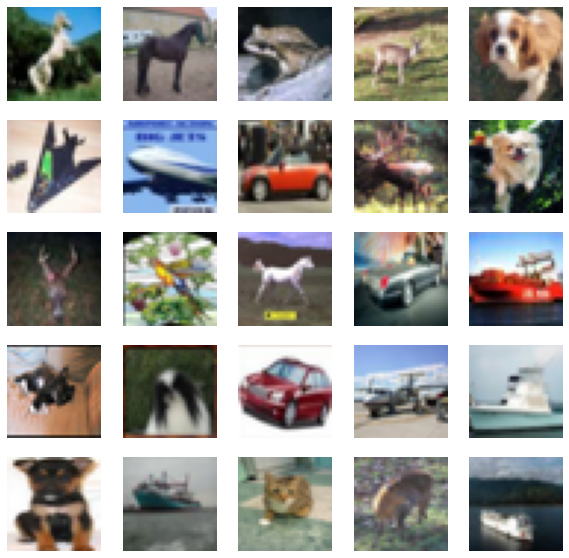

In [13]:
first_batch_images_np = first_batch_images.numpy()

# Plot samples from the first batch
plot_samples(first_batch_images_np)

In [14]:
# Analyze Memory and Time for each layer using CNNMemAnalyzer with the first image of the dataset
cnn_mem_analyzer = CNNMemAnalyzer(network)
_ = cnn_mem_analyzer(first_image)

Layer 1: Conv2d #1
Output shape: torch.Size([1, 32, 32, 32]), Memory usage: 0.13 MB (131.07 KB), Time elapsed: 0.040009 seconds
Layer 2: BatchNorm2d #1
Output shape: torch.Size([1, 32, 32, 32]), Memory usage: 0.13 MB (131.07 KB), Time elapsed: 0.002105 seconds
Layer 3: LeakyReLU #1
Output shape: torch.Size([1, 32, 32, 32]), Memory usage: 0.13 MB (131.07 KB), Time elapsed: 0.001483 seconds
Layer 4: Conv2d #2
Output shape: torch.Size([1, 32, 32, 32]), Memory usage: 0.13 MB (131.07 KB), Time elapsed: 0.000641 seconds
Layer 5: BatchNorm2d #2
Output shape: torch.Size([1, 32, 32, 32]), Memory usage: 0.13 MB (131.07 KB), Time elapsed: 0.000128 seconds
Layer 6: LeakyReLU #2
Output shape: torch.Size([1, 32, 32, 32]), Memory usage: 0.13 MB (131.07 KB), Time elapsed: 0.000042 seconds
Layer 7: MaxPool2d #1
Output shape: torch.Size([1, 32, 16, 16]), Memory usage: 0.03 MB (32.77 KB), Time elapsed: 0.000171 seconds
Layer 8: Dropout #1
Output shape: torch.Size([1, 32, 16, 16]), Memory usage: 0.03 MB (

# Train and Test the network

In [15]:
tr_losses, te_losses, te_accs = [], [], []

# Start the timer
start_time = time.time()

# Training and Testing Loop
for epoch in range(1, hparams['num_epochs'] + 1):
    tr_losses.append(train_epoch(trainloader, network, optimizer, criterion, hparams))
    te_loss, te_acc = test_epoch(testloader, network, hparams)
    te_losses.append(te_loss)
    te_accs.append(te_acc)

# Stop the timer
end_time = time.time()
elapsed_time = end_time - start_time

# Convert elapsed time to minutes and seconds
elapsed_mins = int(elapsed_time / 60)
elapsed_secs = int(elapsed_time % 60)

print(f'Total Training Time: {elapsed_mins}m {elapsed_secs}s')

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.318598
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.716355
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.362940
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.234891
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.441066
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.250514
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.984936
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.467738

Test set: Average loss: 0.9897, Accuracy: 6425/10000 (64%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.267929
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.135947
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.961581
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.977018
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.899341
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.837555
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.855214
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.005069

Test set: Average loss: 0.8305, Accuracy: 7067/10000 (71%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.924841
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.819

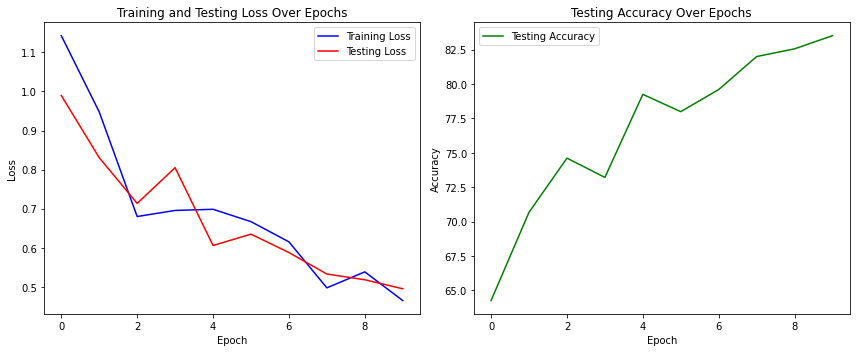

In [16]:
# Plotting Training and Testing Losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(tr_losses, label='Training Loss', color='blue')
plt.plot(te_losses, label='Testing Loss', color='red')
plt.title('Training and Testing Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Testing Accuracy
plt.subplot(1, 2, 2)
plt.plot(te_accs, label='Testing Accuracy', color='green')
plt.title('Testing Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Save the trained model
model_path = "custom_cnn_model.pth"
torch.save(network.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to custom_cnn_model.pth
